# Thermoluminescence Calculations

This Jupyter Notebook providses a convenient and documented to reproduce calculations in the paper.

## Script 1: Second-Order TL Peak Calculation

This script providses the means to calculate the position of the TL peak following second-order kinetics based on the E, s, N and n0, and heating rate. The given equation below describes the intensity 𝐼 of the luminescence as a function of temperature and other parameters. Thermoluminescence is the emission of light from a material when it is heated, and it occurs because trapped electrons in defects within the material are released and recombine with holes, emitting light. The parameters in the equation are defined as follows:

$I = \frac{n_0 s}{N} \exp\left(\frac{E}{kT}\right) \left[ 1 + \frac{n_0 s}{N \beta} \int \exp\left(-\frac{E}{kT}\right) dT \right]^{-2}$

 


𝐼: The intensity of the thermoluminescence emitted by the material. This is the quantity being measured as the material is heated.
n0: The initial concentration of trapped charge carriers (e.g., electrons) in the material before heating begins. This represents the number of electrons initially trapped in defect sites.

𝑠: The frequency factor, also known as the attempt-to-escape frequency. It represents the probability per unit time that a trapped electron will escape from the trap.

𝑁: The total number of available trapping sites in the material. This provides a normalization factor to account for the proportion of traps that are initially filled.

𝐸: The activation energy required to release the trapped electrons. This is the energy barrier that must be overcome for an electron to escape from its trap and contribute to the thermoluminescence signal.

𝑘: The Boltzmann constant, which relates the thermal energy to temperature.

𝑇: The absolute temperature at which the material is being heated, measured in Kelvin. The temperature affects the likelihood of trapped electrons gaining enough energy to escape.

𝛽: The heating rate, which is the rate at which the temperature is increased during the experiment, typically measured in Kelvin per second. This parameter influences the dynamics of how electrons are released as the temperature changes.


Maximum Intensity at 667.0 K.
Plot has been saved as SO_PeakCalc_E1.15eV_s5.0e+08s-1_Tp667.0K.png
Data have been saved as SO_PeakCalc_E1.15eV_s5.0e+08s-1_Tp667.0K.csv


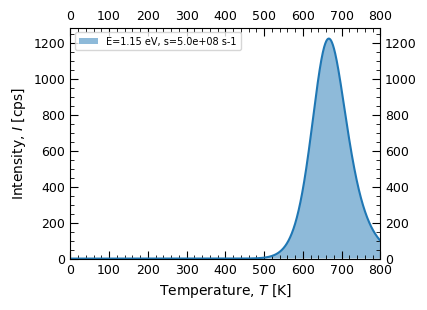

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

## INSTRUCTIONS ##
## Adjust input parameters at the end of script under 'Input parameters'

# Input parameters
E_eV = 1.15    # Activation energy in eV
N = 1E5    # Total concentration of traps
n0 = N*(1/5)  # Initial concentration of electrons in traps
s = 5E8   # Frequency factor
beta = 7.5    # Heating rate

T0 = 1    # Starting temperature for the measurement
T_max = 1000  # Maximum temperature for the measurement

# Constants
k_J_per_K = 1.381e-23  # Boltzmann constant in J/K

# Integral function for second-order kinetics
def integral_second_order(T, T0, E_J, beta, N):
    def integrand(T_prime):
        return np.exp(-E_J / (k_J_per_K * T_prime))
    
    integral_result, _ = quad(integrand, T0, T)
    return integral_result

# Intensity function for second-order kinetics
def intensity_second_order(T, E_J, n0, s, beta, N, T0):
    integral_result = integral_second_order(T, T0, E_J, beta, N)
    numerator = n0**2 * s * np.exp(-E_J / (k_J_per_K * T))
    denominator = N * (1 + (n0 * s) / (beta * N) * integral_result)**2
    return numerator / denominator

# Function to plot I(T) against T and find T at maximum I
def plot_intensity_vs_temperature_and_find_max(E_eV, n0, s, beta, N, T0, T_max):
    # Convert E from eV to J
    E_J = E_eV * 1.602e-19
    
    # Temperature range
    T_range = np.linspace(T0, T_max, 4000)
    
    # Calculate intensity values over the temperature range
    intensity_values = [intensity_second_order(T, E_J, n0, s, beta, N, T0) for T in T_range]
    
    # Find the temperature at maximum intensity
    max_intensity_index = np.argmax(intensity_values)
    max_intensity_temperature = T_range[max_intensity_index]
    
    # Plotting
    plt.figure(figsize=(4, 3))
    plt.fill_between(T_range, intensity_values, alpha=0.5, label=f'E={E_eV} eV, s={s:.1e} s-1')
    plt.plot(T_range, intensity_values, alpha=1)


    plt.minorticks_on()
    plt.tick_params(which='major', axis='both', direction='in', 
                    length=6, labeltop=True, labelright=True, top=True, right=True, labelsize=9)
    plt.tick_params(which='minor', axis='both', direction='in', 
                    length=3, labeltop=False, labelright=False, top=True, right=True)

    plt.xlabel('Temperature, $T$ [K]')
    plt.ylabel('Intensity, $I$ [cps]')
    plt.legend(fontsize=7, loc='best')
    plt.xlim(0,800)
    plt.ylim(0,)
    plt.grid(False)
    plt.show
    
    

    # Generating the CSV file name based on the temperature, E value in eV, and s value
    filename = f"SO_PeakCalc_E{E_eV:.2f}eV_s{s:.1e}s-1_Tp{max_intensity_temperature:.1f}K"

    # Save the plot with the same naming convention
    plt.savefig(f"./calculations/{filename}.png", dpi=600, bbox_inches='tight')


    # Print the temperature of maximum intensity
    print(f'Maximum Intensity at {max_intensity_temperature:.1f} K.')
    print(f"Plot has been saved as {filename}.png")
    print(f"Data have been saved as {filename}.csv")
    
    # Create a DataFrame from the simulation data

    
    df_output_s1 = pd.DataFrame({
        'temp_K': T_range,
        'intensity': intensity_values,
    })

    # Save the DataFrame to a CSV file
    df_output_s1.to_csv(f"./calculations/{filename}.csv", index=False)

# Call the function to plot and find the maximum intensity temperature

plot_intensity_vs_temperature_and_find_max(E_eV, n0, S, beta, N, T0, T_max)


'Trapped_Electrons_T_90K_E_1.15eV_s_5.0e+08'

## Script 2: TL Build-up & Equilibrium over Time

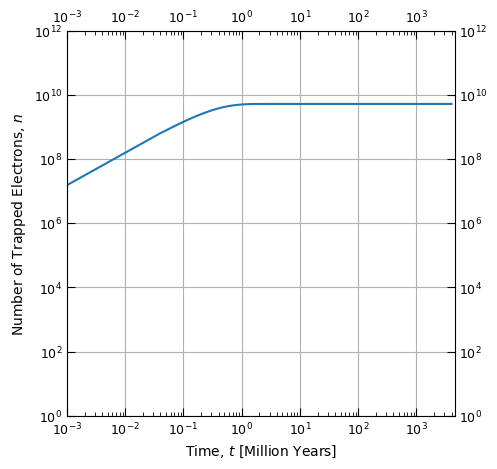

Plot has been saved as Trapped_Electrons_T_90K_E_0.50eV_s_1.0e+15.png
Data has been saved to Trapped_Electrons_T_90K_E_0.50eV_s_1.0e+15


In [152]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## INSTRUCTIONS
## Adjust 'Parameters for the simulation' as desired
## The script will generate a plot and a .csv file with the kinetic parameters in the filename

# Parameters for the simulation
N = 1E12                # Total concentration of traps
R = 3.17E-9             # Dose rate in Gray per second
alpha = 1.7E-7          # Rate constant for trap filling
s = 1E15                # Frequency factor for electron escape
E_eV = 0.5             # Activation energy in eV
T = 90                 # Environment temperature in Kelvin
E = E_eV * 1.602e-19    # Activation energy converted to Joules, no input needed!

# Constants
k_B = 1.381e-23  # Boltzmann constant in J/K

# Differential equation for the dynamics of trap filling and emptying
def trap_dynamics(n, t, N, R, alpha, s, E, T):
    kT = k_B * T
    filling_rate = alpha * (N - n) * R
    emptying_rate = n * s * np.exp(-E / kT)
    return filling_rate - emptying_rate

# Time span for the simulation in seconds (100,000 years)
time_span = np.linspace(0, 4E9 * 365.25 * 24 * 3600, 100000)

# Initial condition: starting with no traps filled
initial_n = 0

# Solving the differential equation using odeint for the new time span
solution_long_term = odeint(trap_dynamics, initial_n, time_span, args=(N, R, alpha, s, E, T))

# Converting time from seconds to millions of years for plotting
time_million_of_years = time_span / (1000000 * 365.25 * 24 * 3600)

# Plotting the results for the long-term simulation
plt.figure(figsize=(5, 5))

plt.minorticks_on()
plt.tick_params(which='major', axis='both', direction='in', 
                    length=6, labeltop=True, labelright=True, top=True, right=True, labelsize=9)
plt.tick_params(which='minor', axis='both', direction='in', 
                    length=3, labeltop=False, labelright=False, top=True, right=True)

plt.plot(time_million_of_years, solution_long_term, label='Number of Trapped Electrons')
plt.xlabel('Time, $t$ [Million Years]')
plt.ylabel('Number of Trapped Electrons, $n$')
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.001,4.5e3)
plt.ylim(1,N)
plt.grid(True)



# Generating the CSV file name based on the temperature, E value in eV, and s value
filename = f"Trapped_Electrons_T_{int(T)}K_E_{E_eV:.2f}eV_s_{s:.1e}"

# Save the plot with the same naming convention
plt.savefig(f"./calculations/{filename}.png")

plt.show()

print(f"Plot has been saved as {filename}.png")

# Create a DataFrame from the simulation data
df_output = pd.DataFrame({
    'Time (Million Years)': time_million_of_years,
    'Number of Trapped Electrons': solution_long_term.flatten()
})


# Save the DataFrame to a CSV file
df_output.to_csv(f"./calculations/{filename}.csv", index=False)

print(f"Data has been saved to {filename}")